In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal=plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle=cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('m5-forecasting-accuracy'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pywt # for deniosing time-series wavelet
# Any results you write to the current directory are saved as output.

m5-forecasting-accuracy/calendar.csv
m5-forecasting-accuracy/sell_prices.csv
m5-forecasting-accuracy/sales_train_validation.csv
m5-forecasting-accuracy/sample_submission.csv


In [3]:
!ls -GFlash m5-forecasting-accuracy

total 642080
     0 drwxr-xr-x@  6 kunalarora  staff   192B May  8 15:35 ./
     0 drwxr-xr-x  17 kunalarora  staff   544B May 10 17:32 ../
   208 -rwxr-xr-x@  1 kunalarora  staff   101K Mar  2 01:48 calendar.csv*
234392 -rwxr-xr-x@  1 kunalarora  staff   114M Mar  2 01:48 sales_train_validation.csv*
 10216 -rwxr-xr-x@  1 kunalarora  staff   5.0M Mar  2 01:48 sample_submission.csv*
397264 -rwxr-xr-x@  1 kunalarora  staff   194M Mar  2 01:48 sell_prices.csv*


In [3]:
# Read the data
INPUT_DIR='m5-forecasting-accuracy/'
cal_data=pd.read_csv(INPUT_DIR+'calendar.csv')
salestv_data=pd.read_csv(INPUT_DIR+'sales_train_validation.csv')
ss_data=pd.read_csv(INPUT_DIR+'sample_submission.csv')
sellp_data=pd.read_csv(INPUT_DIR+'sell_prices.csv')

In [4]:
ss_data.head()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  F10  \
0  HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
1  HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
2  HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
3  HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
4  HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0    0   

   F11  F12  F13  F14  F15  F16  F17  F18  F19  F20  F21  F22  F23  F24  F25  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   F26  F27  F28  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0

In [5]:
salestv_data.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  ...  d_1889  d_1890  d_1891  \
0     0     0     0     0     0     0     0  ...       0       0       0   
1     0     0     0     0     0     0     0  ...       0       0       0   
2     0     0     0     0     0     0     0  ...       0       0       0   
3     0     0     0     0     0     0     0  ...       0       3       1   
4     0     0     0     0     0     0     0  ...       4       0       1   

   d_1892  d_1893  d_1894  d_1895  d_1896  d_1897  d_1898  d_1899  d_1900  \
0       1       0       4       2       3       0       1       2       0   
1       0       0       0       0       0       0       0       0       0   
2       1       0       0       0       1       0       0       0       0   
3       2       1       3       1       0       2       5       4       2   
4       4       0       1       0       1       0       1       1       2   

   d_1901  d_1902  d_1903  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  \
0       0       0       1       1       3       0       1       1       1   
1       0       0       0       0       0       0       0       0       1   
2       0       1       2       2       1       2       1       1       1   
3       0       3       0       1       0       5       4       1       0   
4       0       1       1       2       1       1       0       1       1   

   d_1910  d_1911  d_1912  d_1913  
0       3       0       1       1  
1       0       0       0       0  
2       0       1       1       1  
3       1       3       7       2  
4       2       2       2       4  

[5 rows x 1919 columns]

In [6]:
cal_data.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [7]:
sellp_data.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

# Utility functions

In [8]:
def list_to_df(list_obj):
    return pd.Series(list_obj)

# Visualizing the data for a single item that sells frequently

1. Simply plotting the sales for a specific item to understand the trend

In [9]:
#ids = sorted(list(set(salestv_data['id'])))

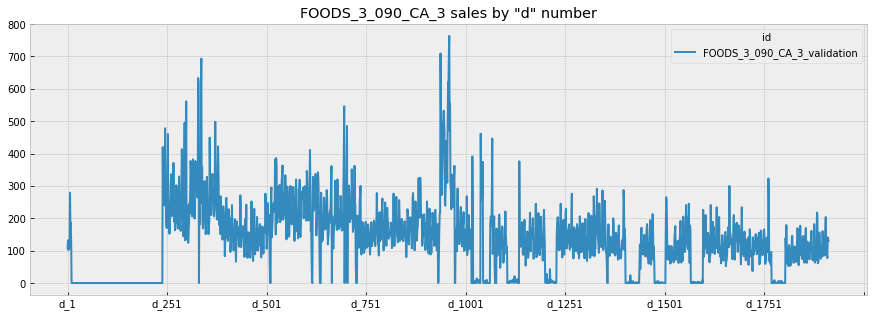

In [10]:
d_cols=[c for c in salestv_data.columns if 'd_' in c]

# Below we are the chaining the following operations
# 1. Select a particular item
# 2. Set id as index, & keep only sales data column starting with d_
# 3. Transform so that dataframe is a column
# 4. Plot the data
salestv_data.loc[salestv_data['id']=='FOODS_3_090_CA_3_validation'] \
.set_index('id')[d_cols] \
.T \
.plot(figsize=(15,5), title='FOODS_3_090_CA_3 sales by "d" number',color=next(color_cycle))
plt.show()

2. Plotting a random sample sales data by merging with calendar data to plot exact dates on x-axis 

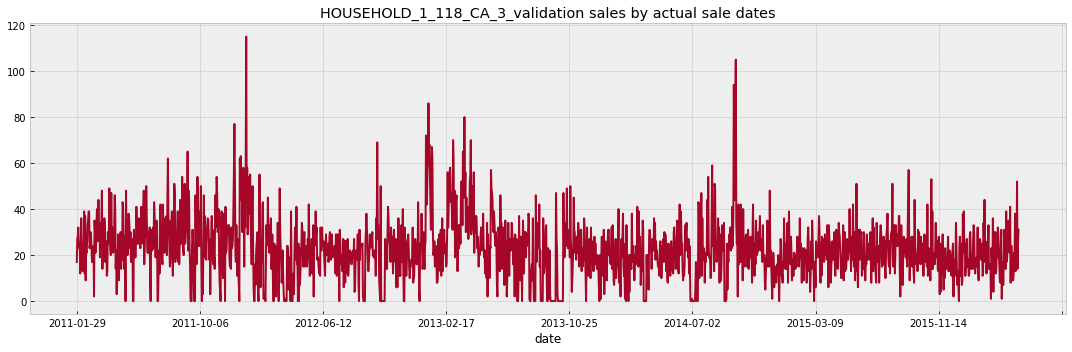

In [11]:
ids = ['FOODS_3_090_CA_3_validation', 'HOBBIES_1_234_CA_3_validation', 'HOUSEHOLD_1_118_CA_3_validation', 'HOBBIES_1_001_CA_1_validation']
examples = []

# General function to extract specific item Id values from sales_train_evaluation dataset
for i in range(len(ids)):
    # Merge calendar date with sales_train_evaluation date
    examples.append(salestv_data.loc[salestv_data['id']== ids[i]][d_cols].T) # Fetch a specific Id and transform it as column
    examples[i] = examples[i].rename(columns={examples[i].columns.values[0] : ids[i]}) # Rename column e.g 8412 (location Id) to the proper name
    examples[i] = examples[i].reset_index().rename(columns={'index':'d'}) # Reset index so, d_cols are not index and then, rename index as d
    examples[i] = examples[i].merge(cal_data) # Merge two dataframe on the bases of column named d


graph_ids = [2]
fig, axs = plt.subplots(len(graph_ids),1,figsize=(15,10)) 
if len(graph_ids) != 1 : axs=axs.flatten() 

ax_id=0
for graph_id in graph_ids:
    # Set date as the index of dataframe to be plotted properly and only fetch specific Id sales value
    examples[graph_id].set_index('date')[ids[graph_id]] \
    .plot(figsize=(15,5), color=next(color_cycle), title= f'{ids[graph_id]} sales by actual sale dates', ax=axs[ax_id] if len(graph_ids)!=1 else axs)
    
    ax_id+=1
plt.tight_layout()
plt.show()

# Creating a specific example for an item Id
#example2 = salestv_data.loc[salestv_data['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
#example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
#example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
#example2 = example2.merge(cal_data, how='left', validate='1:1')


3. Plot the sample sale snippet, kind of zooming technique 

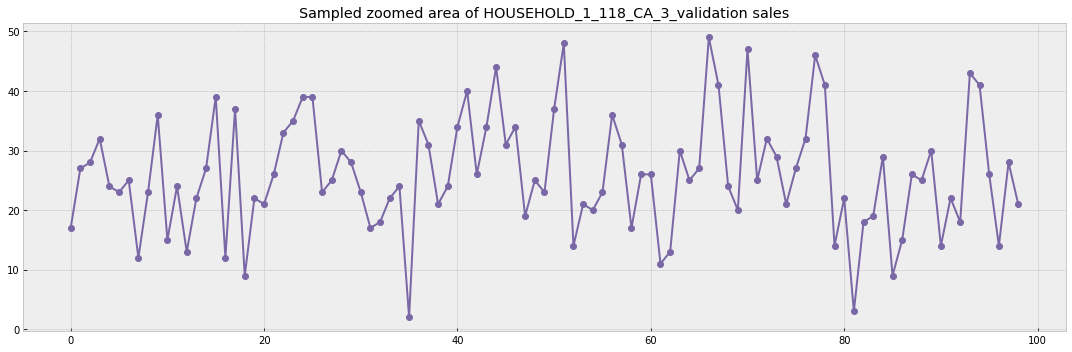

In [12]:
fig, axs = plt.subplots(len(graph_ids),1,figsize=(15,10)) 
if len(graph_ids) != 1 : axs=axs.flatten() 

ax_id=0
for graph_id in graph_ids:
    examples[graph_id][:99][ids[graph_id]].plot(figsize=(15,5),color=next(color_cycle), marker='o',
                                                title=f'Sampled zoomed area of {ids[graph_id]} sales', ax=axs[ax_id] if len(graph_ids)!=1 else axs)
    ax_id+=1
plt.tight_layout()
plt.show()

3. Deniosing sales to know underlying trends  

3.1. Wavelet denoising - calculate wavelet coefficeints and discard low coefficients 

In [13]:
# Return Mean absolute deviation value
def maddest(d, axis=None):
    return np.mean(np.absolute(d-np.mean(d,axis)), axis)

# Denoise the signal
def denoise(x, wavelet='db4',level=1):
    coeff = pywt.wavedec(x,wavelet,mode='per')
    sigma=(1/0.6745)*maddest(coeff[-level])
    
    uthresh=sigma*np.sqrt(2*np.log(len(x)))
    coeff[1:]=(pywt.threshold(i,value=uthresh,mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff,wavelet,mode='per')

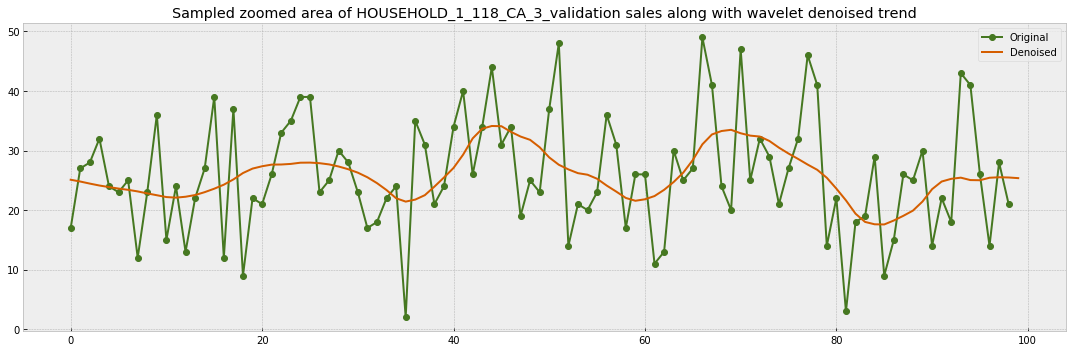

In [14]:
fig, axs = plt.subplots(len(graph_ids),1,figsize=(15,10)) 
if len(graph_ids) != 1 : axs=axs.flatten() 

ax_id=0
for graph_id in graph_ids:
    examples[graph_id][ids[graph_id]][:99].plot(figsize=(15,5),color=next(color_cycle), marker='o', label='Original',
                                                title=f'Sampled zoomed area of {ids[graph_id]} sales along with wavelet denoised trend', ax=axs[ax_id] if len(graph_ids)!=1 else axs)
    list_to_df(denoise(examples[graph_id][ids[graph_id]][:99])).plot(figsize=(15,5),color=next(color_cycle), label='Denoised',
                                                ax=axs[ax_id] if len(graph_ids)!=1 else axs)
    axs[ax_id].legend() if len(graph_ids)!=1 else axs.legend()
    ax_id+=1
    
plt.tight_layout()
plt.show()

Plotting original sales and denoised sales side-by-side for better understanding the trend

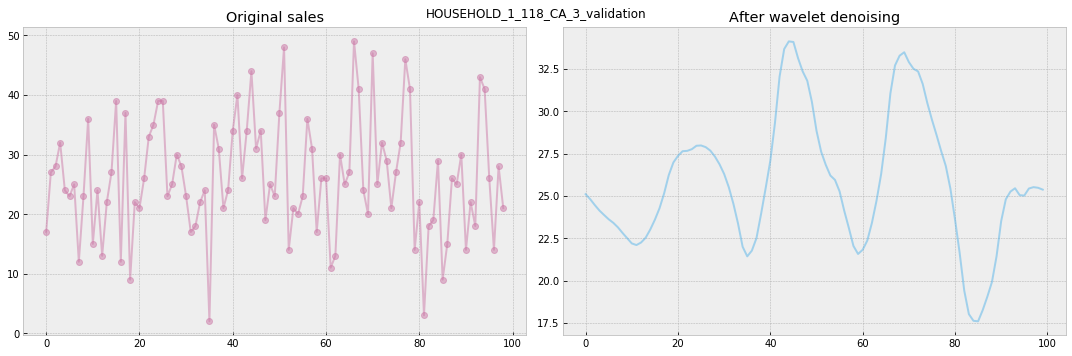

In [15]:
fig, axs = plt.subplots(len(graph_ids),2,figsize=(30,10)) 
axs=axs.flatten() 

ax_id=0
for graph_id in graph_ids:
    examples[graph_id][ids[graph_id]][:99].plot(figsize=(15,5),color=next(color_cycle), marker='o', alpha=0.5,
                                                title='Original sales', ax=axs[ax_id])
    ax_id+=1
    list_to_df(denoise(examples[graph_id][ids[graph_id]][:99])).plot(figsize=(15,5),color=next(color_cycle), alpha=0.5,
                                                                     title='After wavelet denoising', ax=axs[ax_id])
    ax_id+=1
    plt.suptitle(f'{ids[graph_id]}')
plt.tight_layout()
plt.show()

3.2. Average smoothing or rolling mean denoising - A method that uses window & stride concept to denoise the data by taking mean of windowed elements and moving the window by stride 

In [16]:
def average_smoothing(x, window=3, stride=1):
    new_x = []
    start = 0
    end = window
    while end<=len(x):
        new_x.extend(np.ones(end-start)*np.mean(x[start:end]))
        start = start + stride
        end = end + stride
    return np.array(new_x)

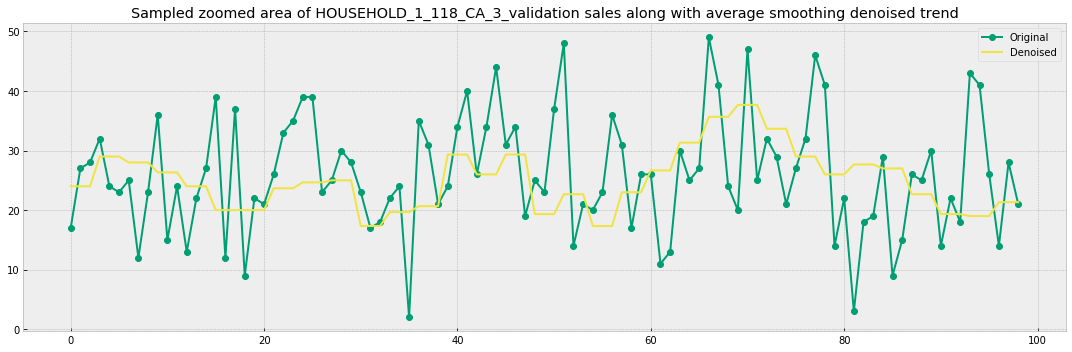

In [17]:
fig, axs = plt.subplots(len(graph_ids),1,figsize=(15,10)) 
if len(graph_ids) != 1 : axs=axs.flatten() 

ax_id=0
for graph_id in graph_ids:
    examples[graph_id][ids[graph_id]][:99].plot(figsize=(15,5),color=next(color_cycle), marker='o', label='Original',
                                                title=f'Sampled zoomed area of {ids[graph_id]} sales along with average smoothing denoised trend', ax=axs[ax_id] if len(graph_ids)!=1 else axs)
    list_to_df(average_smoothing(examples[graph_id][ids[graph_id]])[:99]).plot(figsize=(15,5),color=next(color_cycle), label='Denoised',
                                                ax=axs[ax_id] if len(graph_ids)!=1 else axs)
    axs[ax_id].legend() if len(graph_ids)!=1 else axs.legend()
    ax_id+=1
    
plt.tight_layout()
plt.show()

Plotting original sales and denoised sales side-by-side for better understanding the trend

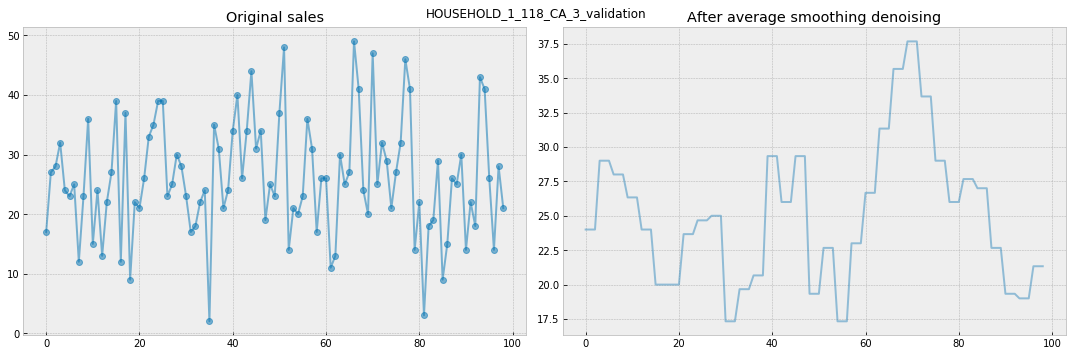

In [18]:
fig, axs = plt.subplots(len(graph_ids),2,figsize=(30,10)) 
axs=axs.flatten() 

ax_id=0
for graph_id in graph_ids:
    examples[graph_id][ids[graph_id]][:99].plot(figsize=(15,5),color=next(color_cycle), marker='o', alpha=0.5,
                                                title='Original sales', ax=axs[ax_id])
    ax_id+=1
    list_to_df(average_smoothing(examples[graph_id][ids[graph_id]])[:99]).plot(figsize=(15,5),color=next(color_cycle), alpha=0.5,
                                                                     title='After average smoothing denoising', ax=axs[ax_id])
    ax_id+=1
    plt.suptitle(f'{ids[graph_id]}')
plt.tight_layout()
plt.show()

# Sales broken down by day of the week, month & year

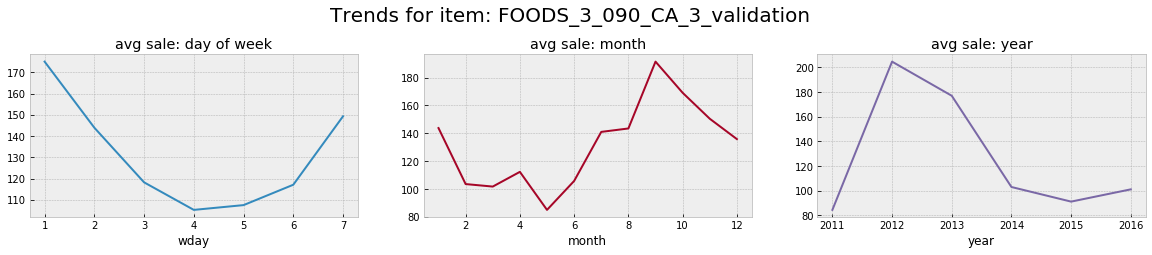

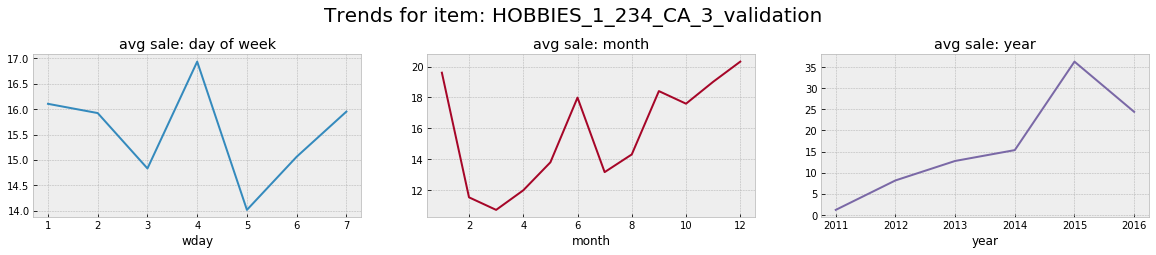

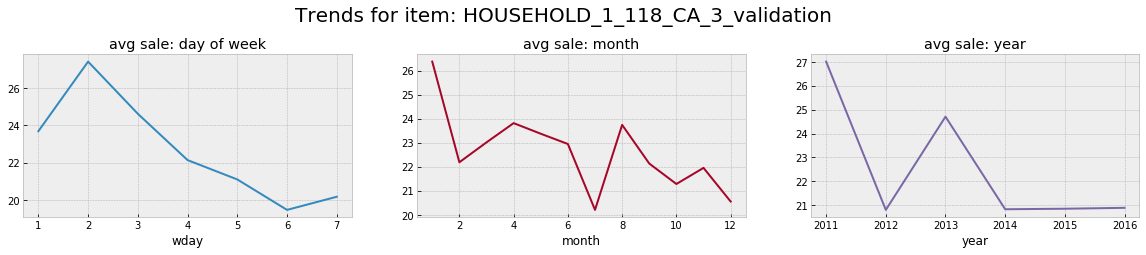

In [19]:
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,3))
    # Groupby wday colum and do mean or count etc. to values of other columns & then, extract the specific sales Id column  
    examples[i].groupby('wday').mean()[ids[i]] \
    .plot(kind='line', title='avg sale: day of week', color=color_pal[0], ax=ax1)
    
    examples[i].groupby('month').mean()[ids[i]] \
    .plot(kind='line', title='avg sale: month', color=color_pal[1], ax=ax2)
    
    examples[i].groupby('year').mean()[ids[i]] \
    .plot(kind='line', title='avg sale: year', color=color_pal[2], ax=ax3)
    
    fig.suptitle(f'Trends for item: {ids[i]}', size=20, y=1.1)

# Visualizing random 20 different items with their sales to analyze some trends

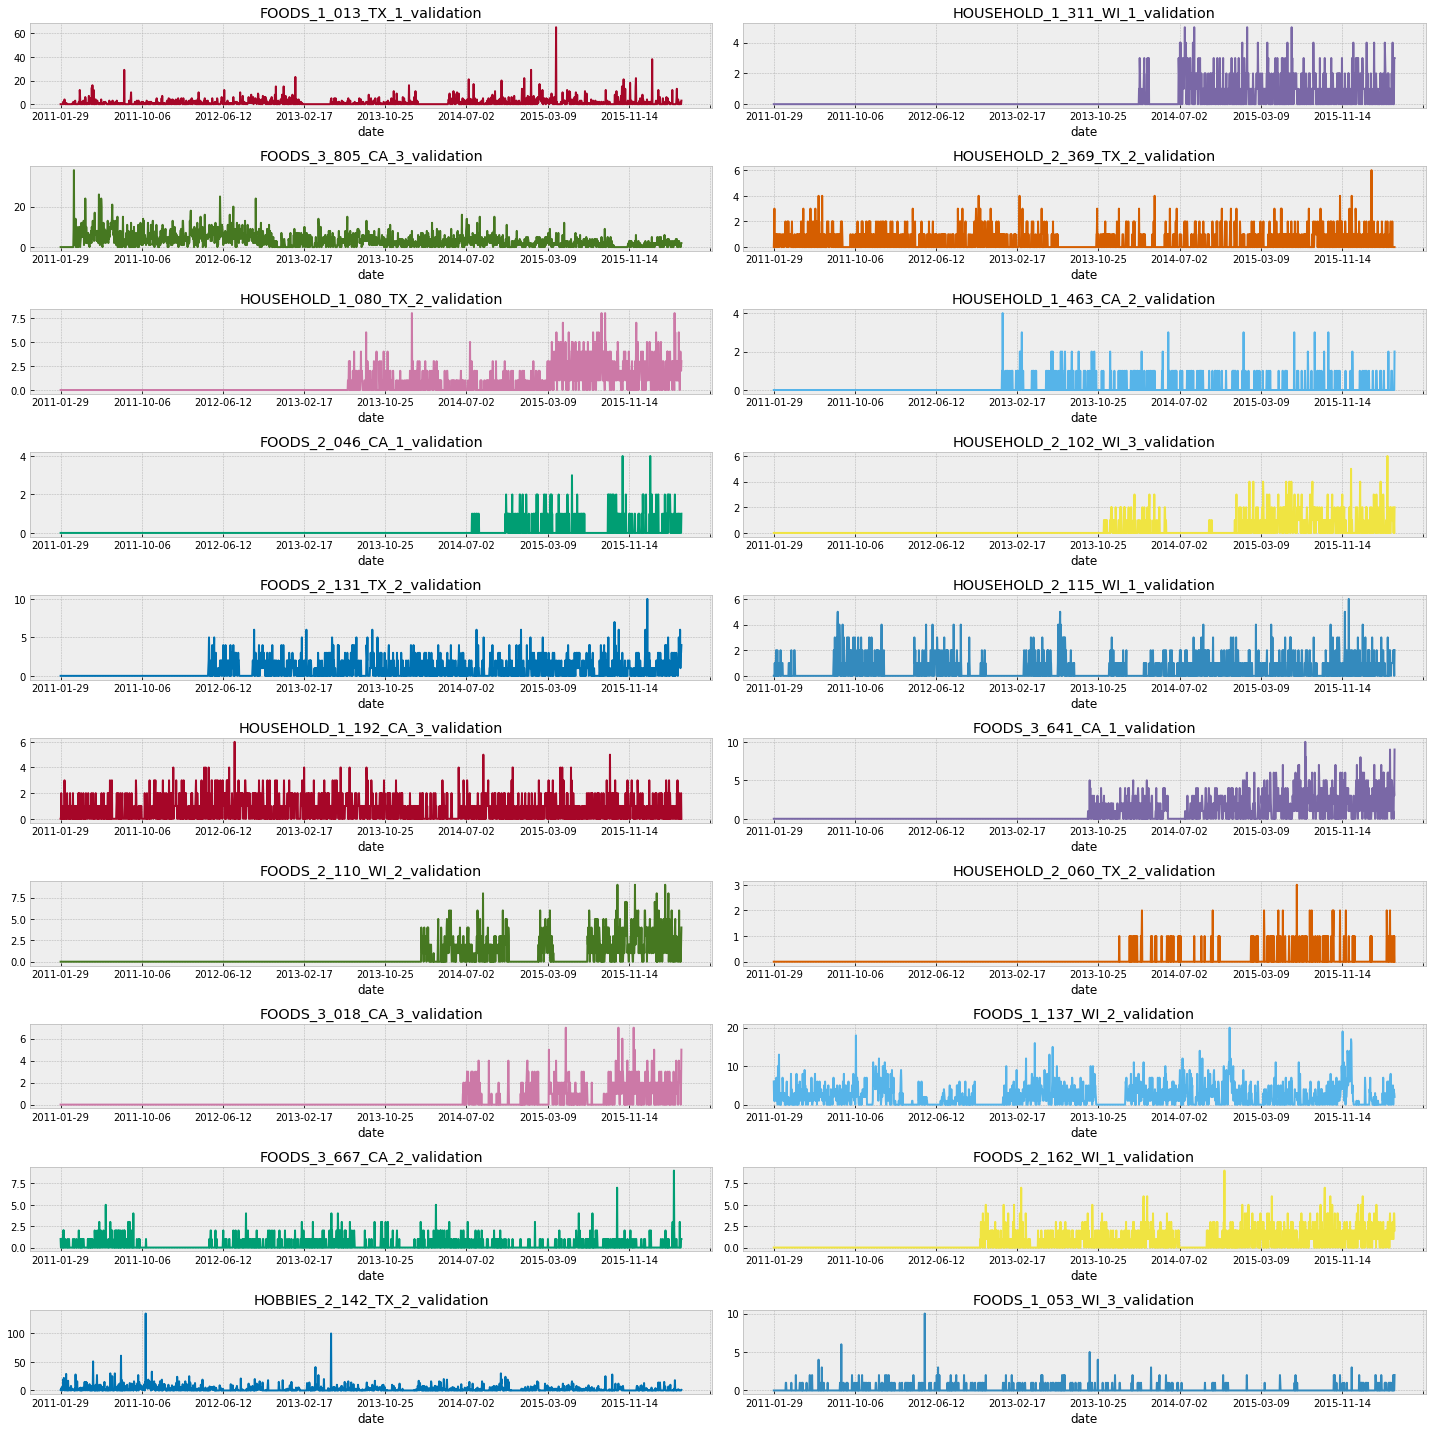

In [20]:
twenty_examples = salestv_data.sample(20, random_state=529) # Sample random 20 samples from the salestv dataframe
list_of_sampled_id = list(twenty_examples['id']) # Extract the list of sampled id of items so as to just keep these id values in the dataframe eventually
twenty_examples = twenty_examples.set_index('id')[d_cols].T # Set the index of dataframe to be id column, select only the d columns & transform the 
twenty_examples = twenty_examples.reset_index().rename(columns={'index':'d'})
twenty_examples = twenty_examples.merge(cal_data)
twenty_examples = twenty_examples.set_index('date')[list_of_sampled_id] 


fig, axs = plt.subplots(10,2,figsize=(20,20))
axs = axs.flatten()

axs_id=0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item, color=next(color_cycle), ax=axs[axs_id])
    axs_id+=1
plt.tight_layout()
plt.show()

# Sales over time by category type

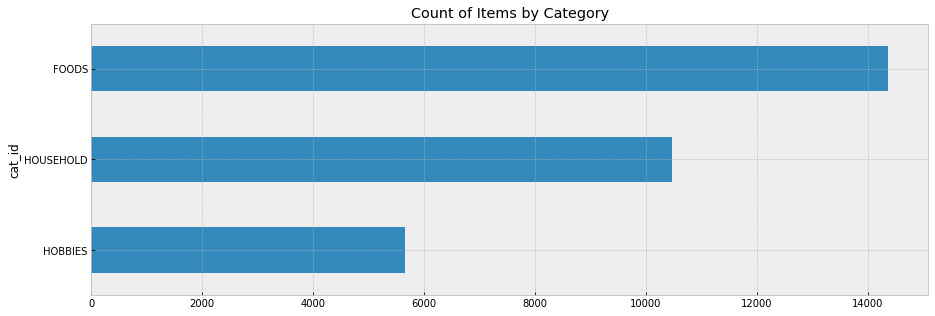

In [21]:
# Plot of count of Items by category
salestv_data.groupby('cat_id').count()['id'].sort_values().plot(kind='barh', title='Count of Items by Category', figsize=(15,5))
plt.show()

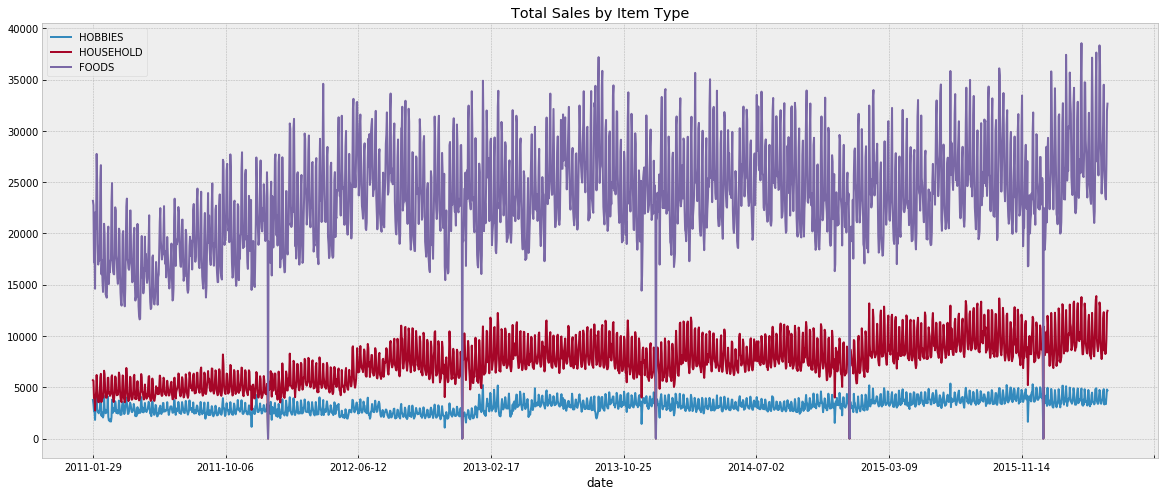

In [22]:
past_sales_item = salestv_data.set_index('id')[d_cols].T \
.merge(cal_data.set_index('d')['date'], left_index=True, right_index=True).set_index('date')

#print(past_sales)
for i in salestv_data['cat_id'].unique():
    items_col = [c for c in past_sales_item.columns if i in c]
    past_sales_item[items_col].sum(axis=1).plot(figsize=(20,8), title='Total Sales by Item Type')

plt.legend(salestv_data['cat_id'].unique())
plt.show()

Roll out of Items being sold

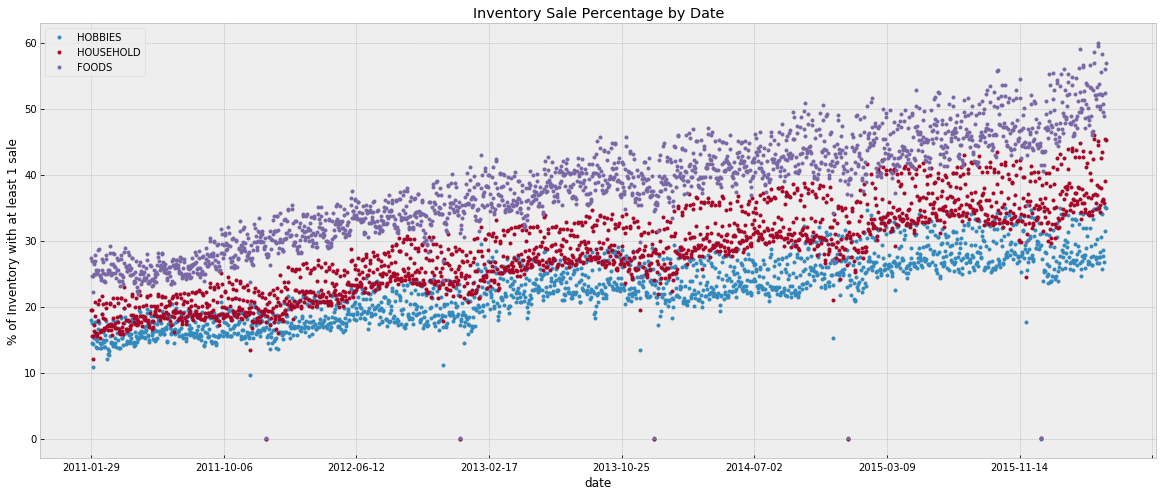

In [23]:
past_sales_clipped = past_sales_item.clip(0,1) # Give the value of 0 or 1 to rows with no value or some value respectively, trim values to input thresholds

for i in salestv_data['cat_id'].unique():
    items_col = [c for c in past_sales_clipped.columns if i in c]
    (past_sales_clipped[items_col].mean(axis=1)*100).plot(figsize=(20,8), style='.', title='Inventory Sale Percentage by Date')
plt.ylabel('% of Inventory with at least 1 sale')
plt.legend(salestv_data['cat_id'].unique())
plt.show()


# Sales by store category

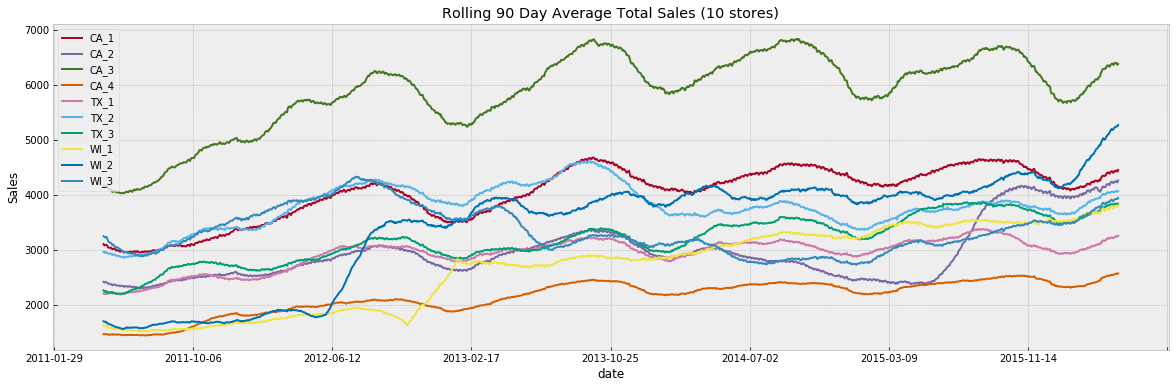

In [24]:
#past_sales_store = salestv_data.groupby('store_id').sum().T \
#.merge(cal_data.set_index('d')['date'], left_index=True, right_index=True).set_index('date')

store_list = sellp_data['store_id'].unique()
for i in store_list:
    # Rolling 90 day average of sales 
    store_items = [c for c in past_sales_item.columns if i in c]
    past_sales_item[store_items].sum(axis=1).rolling(90).mean() \
    .plot(kind='line', figsize=(20,6), color=next(color_cycle), title='Rolling 90 Day Average Total Sales (10 stores)')

plt.ylabel('Sales')
plt.legend(store_list)
plt.show()

Rolling 90 day whisker plot for average sales and store - by matplolib

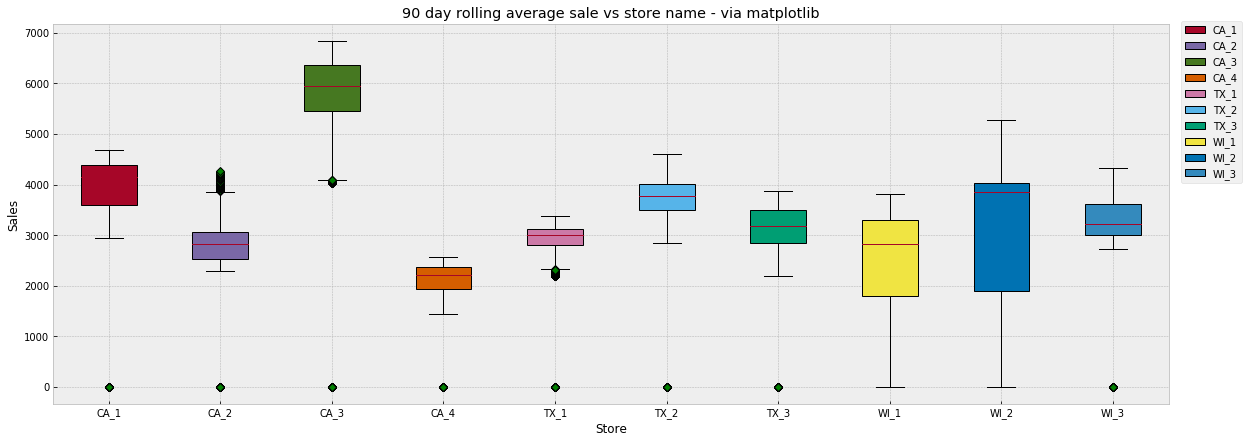

In [25]:
all_data = []

for s in store_list:
    store_items = [c for c in past_sales_item.columns if s in c]
    data = past_sales_item[store_items].sum(axis=1).rolling(90).mean()
    all_data.append(np.nan_to_num(np.array(data)))


plt.figure(figsize=(20,7)) 
green_diamond = dict(markerfacecolor='g', marker='D')
bplot = plt.boxplot(all_data, labels=store_list, flierprops=green_diamond, patch_artist=True, manage_ticks=True)

# fill boxplots with colors
colors = [next(color_cycle) for i in range(0,len(store_list))]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)   

plt.xlabel('Store')
plt.ylabel('Sales')
plt.title('90 day rolling average sale vs store name - via matplotlib')
plt.legend(bplot['boxes'],store_list, bbox_to_anchor=(1.07,1.02))
plt.show()

Rolling 90 day whisker plot for average sales and store - by plotly

In [26]:
import plotly.graph_objects as go
fig=go.Figure()
for i, s in enumerate(store_list):
    store_items = [c for c in past_sales_item.columns if s in c]
    data = past_sales_item[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s))
fig.update_layout(yaxis_title="Sales", xaxis_title="Stores", title="90 day rolling average sale vs store name - via plotly")


ModuleNotFoundError: No module named 'plotly'

Mean sales of store 

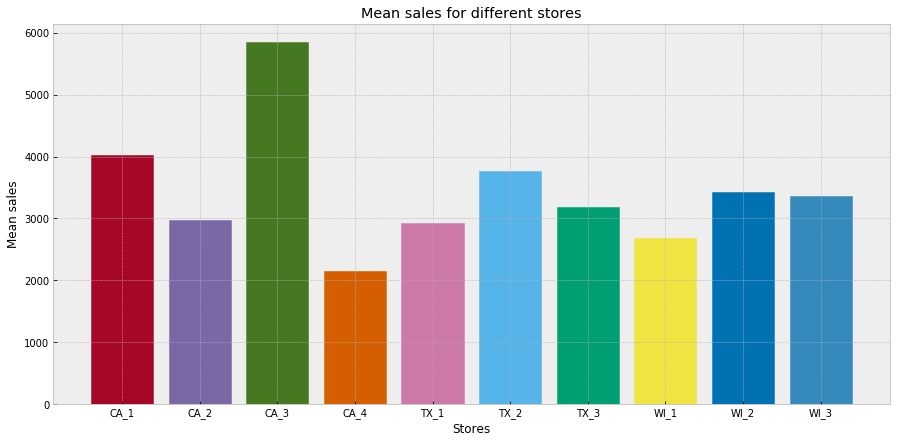

In [27]:
mean_value_store = []
for s in store_list:
    store_items = [c for c in past_sales_item if s in c]
    mean_value_store.append(np.mean(past_sales_item[store_items].sum(axis=1)))

plt.figure(figsize=(15,7))
bplot = plt.bar(store_list,mean_value_store)

#fill different colors for bar plot
colors = [next(color_cycle) for i in range(0,len(store_list))]
for i, b in enumerate(bplot):
    b.set_color(colors[i])
    
plt.xlabel('Stores')
plt.ylabel('Mean sales')
plt.title('Mean sales for different stores')
plt.show()

# Rolling 7 day demand count by store 

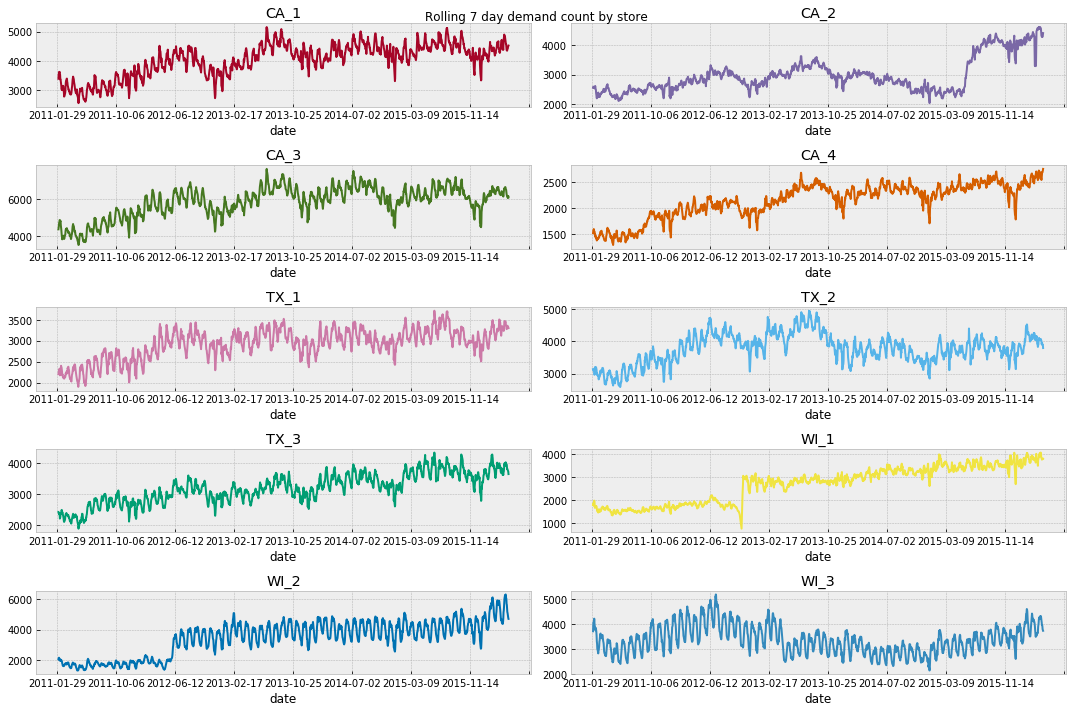

In [28]:
fig, axs = plt.subplots(5,2,figsize=(15,10))
axs=axs.flatten()
ax_id=0

for i in sellp_data['store_id'].unique():
    store_items = [c for c in past_sales_item.columns if i in c]
    past_sales_item[store_items].sum(axis=1) \
    .rolling(7).mean() \
    .plot(title=i, color=next(color_cycle), ax=axs[ax_id])
    
    ax_id+=1

plt.suptitle('Rolling 7 day demand count by store')
plt.tight_layout()
plt.show()


In [29]:
salestv_data.groupby('store_id').sum().T \
.merge(cal_data.set_index('d'), left_index=True, right_index=True).set_index('date').groupby('wday').mean()[sellp_data['store_id'].unique()] 

#fig, axs = plt.subplots(5,2,figsize=(20,20))
#axs=axs.flatten()

#for i in data.columns:
#    data[i].plot(color=next(color_cycle))

CA_1         CA_2         CA_3         CA_4         TX_1  \
wday                                                                    
1     5064.722628  3981.040146  6722.861314  2395.810219  3451.700730   
2     5129.744526  3808.335766  7039.007299  2460.916058  3661.901460   
3     3853.578755  2620.098901  5882.446886  2176.714286  2806.963370   
4     3410.919414  2449.021978  5379.721612  1999.073260  2584.556777   
5     3320.036630  2445.769231  5196.124542  1940.783883  2575.417582   
6     3359.666667  2507.120879  5138.490842  1947.967033  2584.772894   
7     4022.582418  2985.996337  5573.282051  2092.725275  2804.205128   

             TX_2         TX_3         WI_1         WI_2         WI_3  
wday                                                                   
1     4505.357664  3678.284672  3642.175182  3974.427007  4130.514599  
2     4624.875912  3780.302920  3137.113139  3613.996350  3873.828467  
3     3657.630037  3184.633700  2308.813187  3230.150183  3131.937729  
4     3279.161172  2874.747253  2244.626374  3159.260073  2987.692308  
5     3284.457875  2818.809524  2310.318681  3200.369963  2917.934066  
6     3333.161172  2830.736264  2331.842491  3205.183150  2966.065934  
7     3708.227106  3110.402930  2861.311355  3559.556777  3507.695971

# Sale prices EDA

1. Sale price of one of the most selling product over the years along different stores

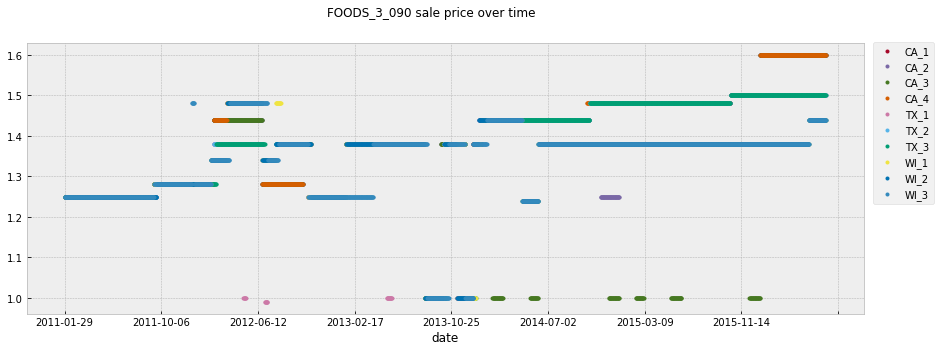

In [30]:
fig, axs = plt.subplots(figsize=(15,5))
stores=[]

for store, d in sellp_data.query('item_id == "FOODS_3_090"').groupby('store_id'):
    # Merge cal_data with wm_yr_wk to plot against actual dates
    merged_d = d.set_index('wm_yr_wk').merge(cal_data.set_index('wm_yr_wk'),left_index=True, right_index=True)
    # Plot the sales over time 
    merged_d.plot(x='date', y='sell_price', color=next(color_cycle), ax=axs, legend=store, style='.')
    stores.append(store)

plt.legend(stores, bbox_to_anchor=(1.09,1.02))
plt.suptitle('FOODS_3_090 sale price over time')
plt.show()

2. Log distribution of sale price for different food categories 

In [31]:
# Add a category column to sellp data 
sellp_data['Category'] = sellp_data['item_id'].apply(lambda x: x.split('_')[0])

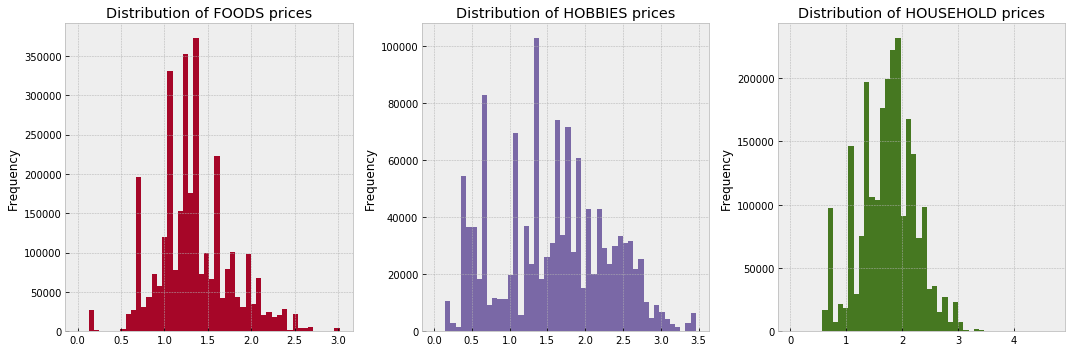

In [32]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
ax_id=0

for cat, d in sellp_data.groupby('Category'):
    # Do the log of values of sell_price columns & plot it's histogram distribution
    d['sell_price'].apply(np.log1p).plot(kind='hist', bins=50,ax=axs[ax_id], color=next(color_cycle), title=f"Distribution of {cat} prices")
    ax_id+=1
        
plt.tight_layout()
plt.show()

# Modeling

In [33]:
train_dataset = salestv_data[d_cols[-100:-30]]
val_dataset = salestv_data[d_cols[-30:]]

print(val_dataset.values)

[[1 1 1 ... 0 1 1]
 [1 1 1 ... 0 0 0]
 [1 0 0 ... 1 1 1]
 ...
 [0 1 1 ... 0 1 0]
 [2 4 3 ... 3 1 3]
 [0 5 7 ... 0 0 0]]


In [34]:
# Utility function to plot graph
def plot_graphs(ids=[0,2], pred=[], pred_value=False):
    fig, axs = plt.subplots(len(ids), 1, figsize=(20,5))
    if len(ids)!=1 : axs = axs.flatten()
    
    if len(ids)==1:
        axs.plot(list(train_dataset.loc[ids[0]].keys()), train_dataset.loc[ids[0]].values)
        axs.plot(list(val_dataset.loc[ids[0]].keys()), val_dataset.loc[ids[0]].values)
        if pred_value and pred.any():
            axs.plot(list(val_dataset.loc[ids[0]].keys()), pred[ids[0]])
        axs.tick_params(axis='x', rotation=90)
    else:
        ax_id=0
        for i in ids:
            axs[ax_id].plot(list(train_dataset.loc[i].keys()), train_dataset.loc[i].values)
            axs[ax_id].plot(list(val_dataset.loc[i].keys()), val_dataset.loc[i].values)
            if pred_value and pred.any():
                axs[ax_id].plot(list(val_dataset.loc[i].keys()), pred[i])
            axs[ax_id].tick_params(axis='x', rotation=90)
            ax_id+=1
    plt.suptitle('Plot of few items with train and validation data respectively')
    plt.tight_layout()
    plt.show()   

    Plot the train & validation data to compare further model predictions 

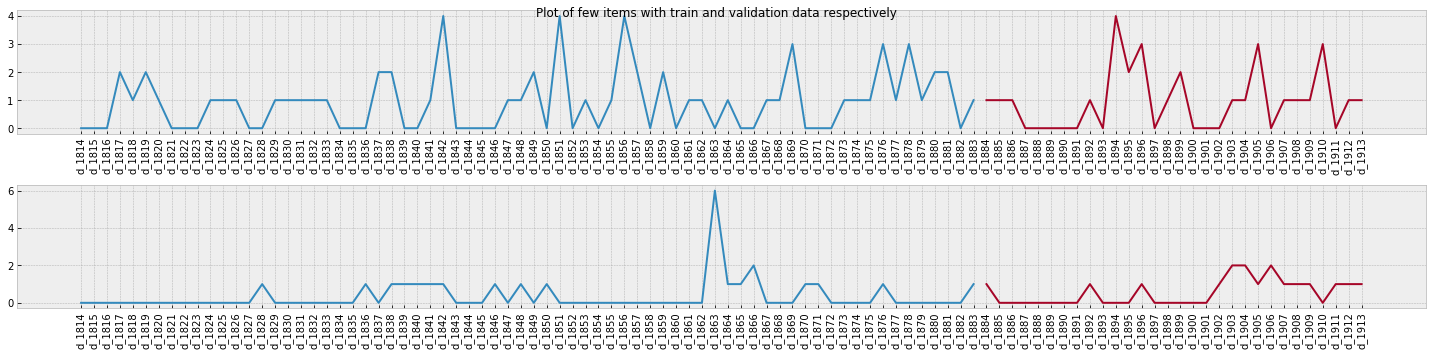

In [35]:
ids = [0, 2]
plot_graphs(ids, [], False)

1. Naive approach - forecast the next day sales as current day sales

In [36]:
def naive_approach():
    predictions=[]
    for i in range(len(val_dataset.columns)):
        if i==0:
            predictions.append(train_dataset[train_dataset.columns[-1]].values)
        else:
            predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    predictions = np.transpose(np.array([list(row) for row in predictions]))
    error_norm = np.linalg.norm(predictions[:3]-val_dataset[:3]/len(predictions[0]))
    return predictions, float(error_norm)

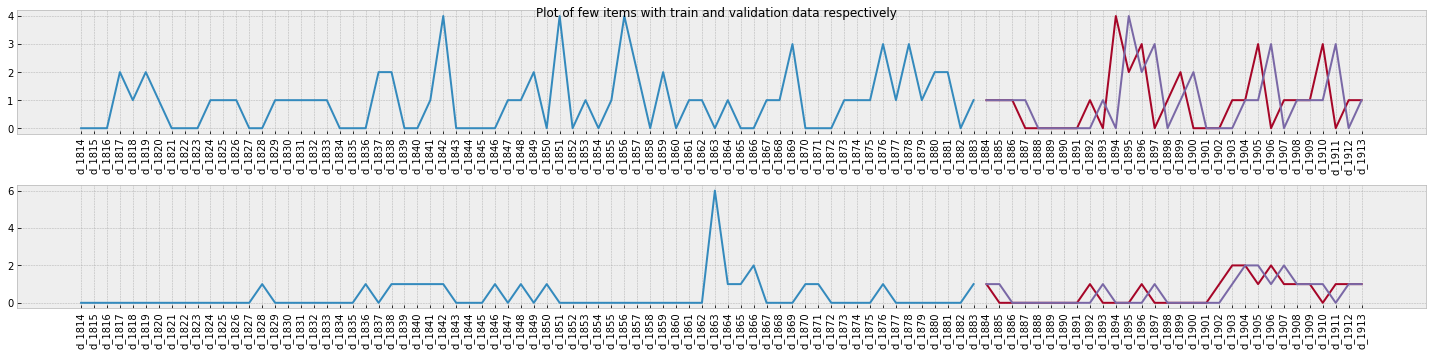

In [37]:
ids=[0, 2]
pred, error_naive=naive_approach()
plot_graphs(ids, pred, True)

2. Moving average - Take past days (like 30) into consideration to predict the future values 

In [38]:
def moving_average(window=30):
    predictions = []
    for i in range(0, len(val_dataset.columns)):
        if i==0:
            predictions.append(np.mean(train_dataset[train_dataset.columns[-window:]].values, axis=1))
        if i>0 and i<=window:
            predictions.append(np.mean(train_dataset[train_dataset.columns[-window+i:]].values, axis=1) + np.mean(val_dataset[val_dataset.columns[:i]].values, axis=1))
        if i>(window+1):
            predictions.append(np.mean(val_dataset[val_dataset.columns[:i]].values, axis=1))
    predictions=np.transpose(np.array([list(row) for row in predictions]))
    error_norm = np.linalg.norm(predictions[:3]-val_dataset[:3]/len(predictions[0]))
    return predictions, float(error_norm)

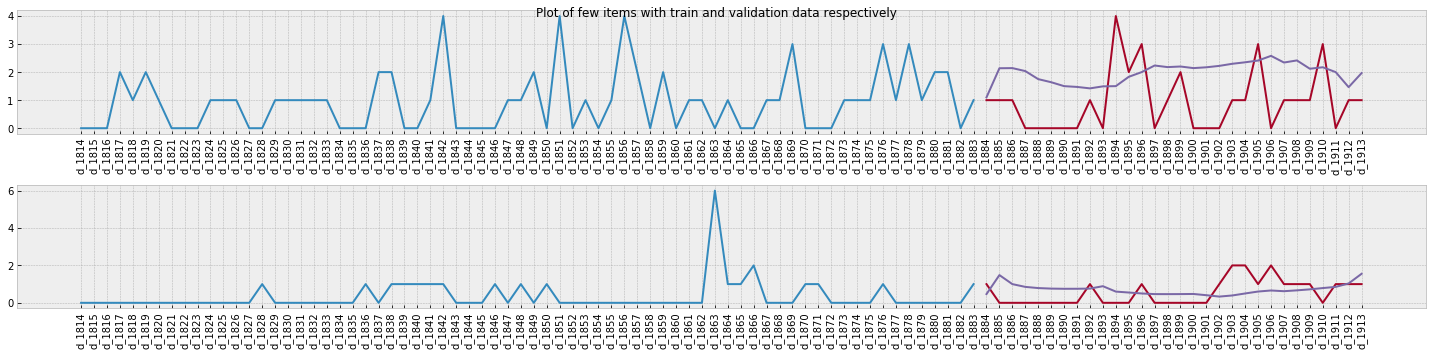

In [39]:
ids=[0, 2]
pred, error_moving = moving_average()
plot_graphs(ids, pred, True)

3. Hot Linear -  Exponential smoothing with trend but no seasonality https://www.youtube.com/watch?v=DUyZl-abnNM

In [40]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from tqdm.notebook import tqdm as tqdm

In [41]:
def holt_smoothing():
    predictions = []
    for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
        fit = Holt(row).fit(smoothing_level=0.3, smoothing_slope=0.01)
        predictions.append(fit.forecast(30))
    predictions=np.array(predictions).reshape(-1,30)
    error_norm = np.linalg.norm(predictions[:3] - val_dataset[:3]/len(predictions[0]))
    return predictions, float(error_norm)

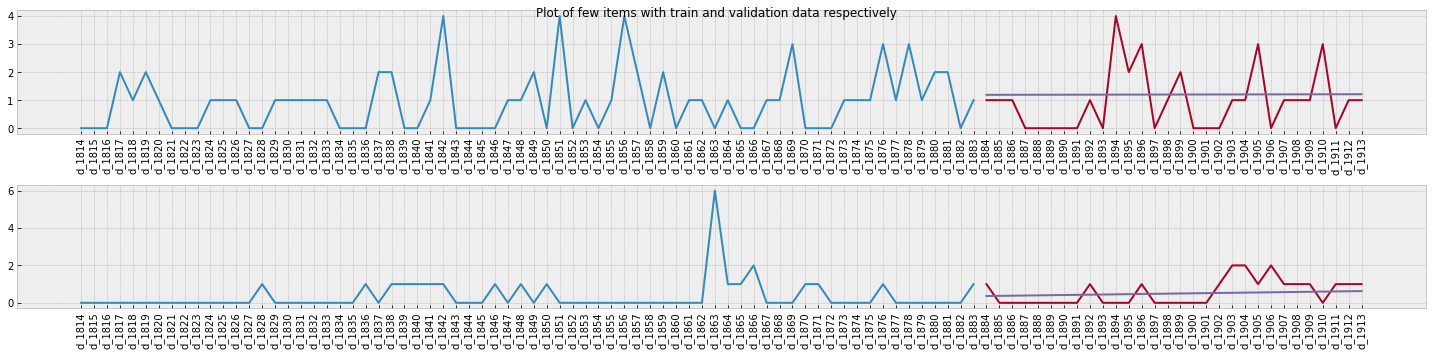

In [42]:
ids = [0, 2]
pred, error_holt= holt_smoothing()
plot_graphs(ids, pred, True)

4. Exponential smoothing or holt-Winter smoothing - This take both trend and seasonality into consideration https://www.youtube.com/watch?v=mrLiC1biciY

In [43]:
def winter_smoothing():
    predictions = []
    for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
        fit = ExponentialSmoothing(row, seasonal_periods=3).fit()
        predictions.append(fit.forecast(30))
    predictions = np.array(predictions).reshape(-1, 30) # Reshaping to make sure it has 30 columns
    error_norm = np.linalg.norm(predictions[:3] - val_dataset[:3]/len(predictions[0]))
    return predictions, float(error_norm)

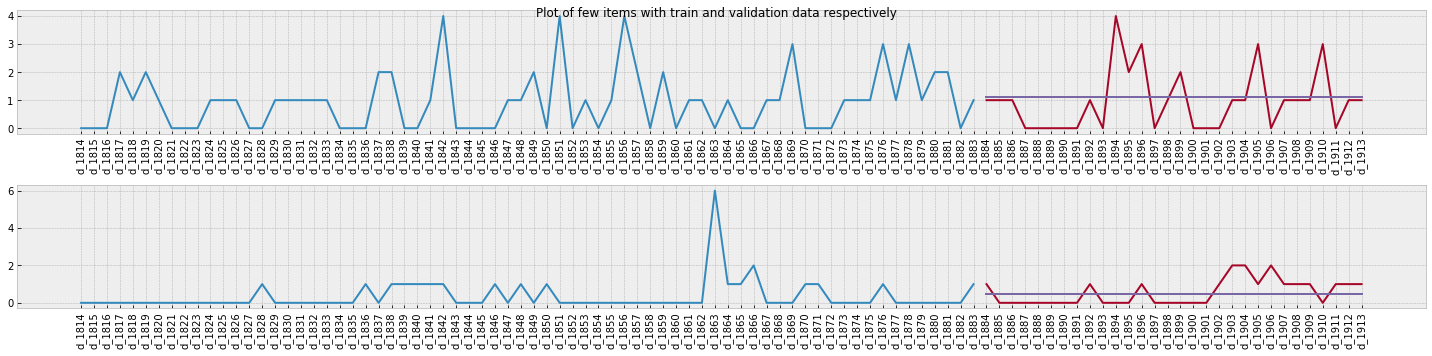

In [44]:
ids = [0, 2]
pred, error_winter = winter_smoothing()
plot_graphs(ids, pred, True)

5. ARIMA model - Auto Regressive Integrated Moving Average, aim to describe correlations in time series https://www.youtube.com/watch?v=2XGSIlgUBDI

In [45]:
# Testing for stationarity using dickey fuller's test
from statsmodels.tsa.stattools import adfuller

In [46]:
def adfuller_test(val):
    result = adfuller(val)
    labels = ['ADF test statistics', 'p-value', '#Lags used', 'No of observations used']
    for value, label in zip(result, labels):
        print(label + ':' + str(value))
    if result[1] <= 0.05:
        print('Stationary')
    else:
        print('Non-stationary')

In [47]:
adfuller_test(train_dataset[train_dataset.columns[-30:]].values[2:3][0])

ADF test statistics:-2.3516987258045954
p-value:0.15583549661055118
#Lags used:2
No of observations used:27
Non-stationary


ADF test statistics:-1.2367414008368363
p-value:0.6575942439327376
#Lags used:9
No of observations used:13
Non-stationary


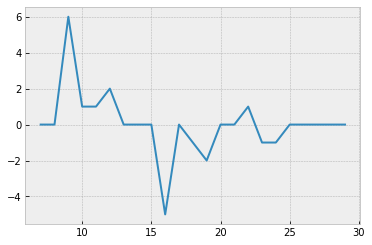

In [48]:
# Differencing to make it stationary
example = (train_dataset[train_dataset.columns[-30:]].loc[2]).reset_index()
example.columns = ['index', 'sales']

# Number by which the seasonality is present, if the seasonal cycle is 1 cycle in 12 months then, we pass 12 
example['seasonal first difference'] = example['sales'] - example['sales'].shift(7) #For us it is 7 
#print(example)
adfuller_test(example['seasonal first difference'].dropna())
example['seasonal first difference'].plot()
plt.show()

Auto-correlation and partial auto-correlation to determine the lags as in how many previous days data I need to consider to make good predictions

p,d,q - p for AR model lags, d for differencing, q for MA lags  
AR model lags are best estimated with PACF, and MA model is best done with ACF

In [53]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

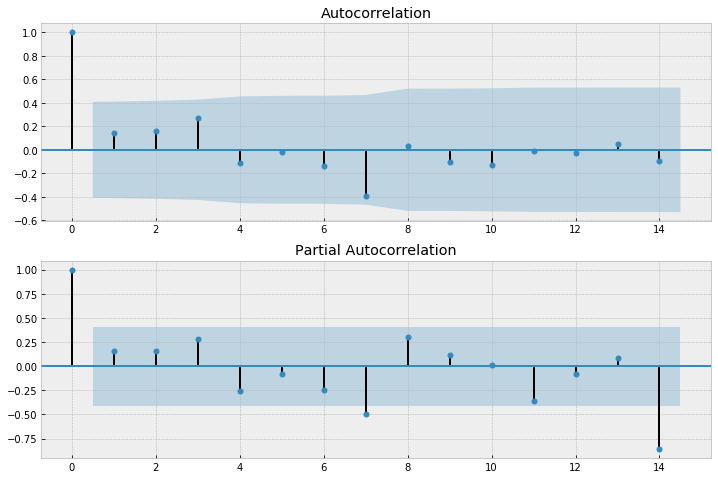

In [61]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(example['seasonal first difference'].dropna(),ax=ax1)
ax2=fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(example['seasonal first difference'].dropna(),ax=ax2)

In [65]:
(train_dataset[train_dataset.columns[-1:]].d_1883.values)

array([1, 1, 1, ..., 2, 1, 2])

In [59]:
def arima():
    predictions = []
    for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
        fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0,1,1,7)).fit()
        predictions.append(fit.forecast(30))
        print(fit.aic)
    predictions = np.array(predictions).reshape(-1, 30)
    error_norm = np.linalg.norm(predictions[:3]-val_dataset[:3]/len(predictions[0]))
    return predictions, float(error_norm)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


84.97020193734444
39.3669034161015
87.72709484787109



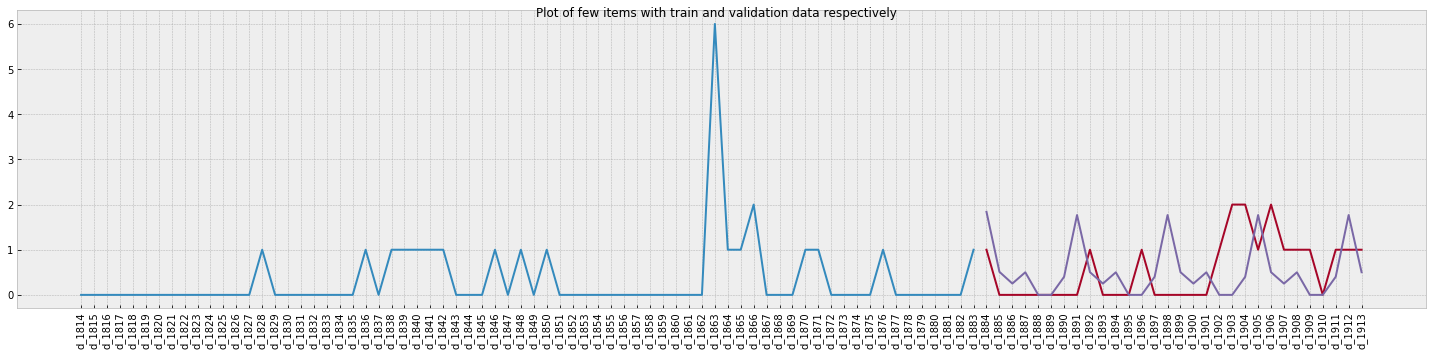

In [60]:
ids = [2]
pred, error_arima = arima()
plot_graphs(ids, pred, True)

6. facebook prophet - additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, including holiday effects https://www.youtube.com/watch?v=95-HMzxsghY 

In [ ]:
from fbprophet import Prophet

In [ ]:
def prophet():
    predictions = []
    forecasts = []
    models = []
    dates = ["2007-12-" + str(i) for i in range(1, 31)]
    for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
        df = pd.DataFrame(np.transpose([dates, row]))
        df.columns = ['ds', 'y']
        model = Prophet(daily_seasonality=True)
        model.fit(df)
        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)
        forecasts.append(forecast)
        models.append(model)
        predictions.append(forecast['yhat'].loc[30:].values)
    predictions = np.array(predictions).reshape(-1,30)
    error_norm = np.linalg.norm(predictions[:3] - val_dataset[:3]/len(predictions[0]))
    return predictions, float(error_norm), forecasts, models

In [ ]:
ids = [2]
pred, error_prophet, forecasts, models = prophet()
plot_graphs(ids, pred, True)

Plotting prophet forecast

In [ ]:
model2 = models[2]
forecast2 = forecasts[2]

model2.plot(forecast2)

Plotting forecast componenets

In [ ]:
model2.plot_components(forecast2)

In [ ]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

In [ ]:
fig = plot_plotly(model2, forecast2)
py.iplot(fig)

7. Error Loss of all models 

In [ ]:
x_axis = ['Naive', 'Moving Average', 'Holt linear', 'Holt-Winter', 'ARIMA', 'Prophet']
y_axis = [error_naive, error_moving, error_holt, error_winter, error_arima, error_prophet]
loss_df = pd.DataFrame(np.transpose([x_axis, y_axis]))
loss_df.columns = ['model', 'error']
for i in range(6):
    loss_df['error'][i] = float(loss_df['error'][i])

plt.figure(figsize=(15,5))
bplot = plt.bar(x_axis, loss_df['error'])

#fill different colors for bar plot
colors = [next(color_cycle) for i in range(0,6)]
for i, b in enumerate(bplot):
    b.set_color(colors[i])
    
plt.xlabel('Models')
plt.ylabel('Error loss')
plt.show()